# Personal Health & Wellness ML Models

This notebook generates synthetic health data matching Apple HealthKit fields and implements ML models for:
1. **Synthetic Data Generation** - Realistic health metrics with correlations
2. **Correlation Analysis** - Find relationships between metrics
3. **Anomaly Detection** - Identify unusual health patterns
4. **Trend Analysis** - Track changes over time


In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)



## 1. Synthetic Health Data Generation

Generate 90 days of realistic health data matching Apple HealthKit fields with built-in correlations and patterns.


In [110]:
def generate_synthetic_health_data(days=90, seed=42):
    """
    Generate realistic synthetic health data matching Apple HealthKit fields.
    
    Parameters:
    - days: Number of days of historical data (default: 90)
    - seed: Random seed for reproducibility
    
    Returns:
    - DataFrame with daily health metrics
    """
    np.random.seed(seed)
    
    # Generate date range
    end_date = datetime.now()
    start_date = end_date - timedelta(days=days-1)
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Initialize data structure
    data = {'date': dates}
    
    # Base sleep quality (will influence other metrics)
    base_sleep = np.random.normal(7, 1, days)
    sleep_quality = np.clip(base_sleep, 4, 10)
    
    # Sleep Analysis (hours)
    data['sleep_hours'] = sleep_quality + np.random.normal(0, 0.3, days)
    data['sleep_hours'] = np.clip(data['sleep_hours'], 4, 10)
    
    # Step Count (correlated with sleep - better sleep = more steps)
    base_steps = 8000 + (sleep_quality - 7) * 1500
    data['step_count'] = base_steps + np.random.normal(0, 2000, days)
    data['step_count'] = np.clip(data['step_count'], 2000, 25000).astype(int)
    
    # Resting Heart Rate (inversely correlated with sleep quality)
    base_rhr = 65 - (sleep_quality - 7) * 2
    data['resting_heart_rate'] = base_rhr + np.random.normal(0, 3, days)
    data['resting_heart_rate'] = np.clip(data['resting_heart_rate'], 50, 90).astype(int)
    
    # Heart Rate Variability SDNN (positively correlated with sleep)
    base_hrv = 50 + (sleep_quality - 7) * 8
    data['hrv_sdnn'] = base_hrv + np.random.normal(0, 10, days)
    data['hrv_sdnn'] = np.clip(data['hrv_sdnn'], 20, 150).astype(int)
    
    # Average Heart Rate during day
    data['heart_rate_avg'] = data['resting_heart_rate'] + np.random.normal(15, 5, days)
    data['heart_rate_avg'] = np.clip(data['heart_rate_avg'], 60, 120).astype(int)
    
    # Active Energy Burned (correlated with steps)
    data['active_energy_burned'] = (data['step_count'] * 0.04) + np.random.normal(0, 50, days)
    data['active_energy_burned'] = np.clip(data['active_energy_burned'], 100, 1000).astype(int)
    
    # Exercise Time (minutes, correlated with steps and energy)
    base_exercise = (data['step_count'] - 5000) / 200
    data['exercise_time_minutes'] = base_exercise + np.random.normal(0, 10, days)
    data['exercise_time_minutes'] = np.clip(data['exercise_time_minutes'], 0, 120).astype(int)
    
    # Walking + Running Distance (km, correlated with steps)
    data['distance_walking_running'] = (data['step_count'] * 0.0007) + np.random.normal(0, 0.5, days)
    data['distance_walking_running'] = np.clip(data['distance_walking_running'], 0.5, 20).round(2)
    
    # Cycling Distance (km, independent with some variation)
    cycling_days = np.random.binomial(1, 0.3, days)  # 30% of days have cycling
    data['distance_cycling'] = cycling_days * np.random.uniform(0, 15, days)
    data['distance_cycling'] = data['distance_cycling'].round(2)
    
    # Walking Speed (km/h)
    data['walking_speed'] = 4.5 + np.random.normal(0, 0.5, days)
    data['walking_speed'] = np.clip(data['walking_speed'], 3.0, 6.5).round(2)
    
    # VO2 Max (ml/kg/min, slowly changes over time, correlated with fitness)
    base_vo2max = 35 + (data['exercise_time_minutes'].mean() / 10)
    trend = np.linspace(0, 2, days)  # Slight improvement over time
    data['vo2_max'] = base_vo2max + trend + np.random.normal(0, 1.5, days)
    data['vo2_max'] = np.clip(data['vo2_max'], 25, 55).round(1)
    
    # Dietary metrics
    # Dietary Energy Consumed (calories)
    data['dietary_energy_consumed'] = np.random.normal(2000, 300, days)
    data['dietary_energy_consumed'] = np.clip(data['dietary_energy_consumed'], 1200, 3500).astype(int)
    
    # Dietary Sugar (grams)
    data['dietary_sugar'] = np.random.normal(50, 15, days)
    data['dietary_sugar'] = np.clip(data['dietary_sugar'], 10, 120).astype(int)
    
    # Dietary Water (liters)
    data['dietary_water'] = np.random.normal(2.5, 0.5, days)
    data['dietary_water'] = np.clip(data['dietary_water'], 1.0, 4.5).round(2)
    
    # Body Mass (kg) - slowly changing over time
    base_weight = 75  # Starting weight
    weight_trend = np.linspace(0, -1, days)  # Slight weight loss trend
    data['body_mass'] = base_weight + weight_trend + np.random.normal(0, 0.3, days)
    data['body_mass'] = data['body_mass'].round(1)
    
    # Height (cm) - constant for adults
    data['height'] = 175 + np.random.normal(0, 0.1, days)
    data['height'] = data['height'].round(1)
    
    # Convert to DataFrame first
    df = pd.DataFrame(data)
    
    # Add some realistic anomalies (poor sleep periods, high activity days, sick days)
    # Simulate a "bad week" around day 30
    bad_week_start = 30
    bad_week_end = 37
    df.loc[bad_week_start:bad_week_end, 'sleep_hours'] *= 0.7
    df.loc[bad_week_start:bad_week_end, 'resting_heart_rate'] *= 1.15
    df.loc[bad_week_start:bad_week_end, 'hrv_sdnn'] *= 0.75
    df.loc[bad_week_start:bad_week_end, 'step_count'] *= 0.6
    
    # Simulate a "very active week" around day 60
    active_week_start = 60
    active_week_end = 67
    df.loc[active_week_start:active_week_end, 'step_count'] *= 1.4
    df.loc[active_week_start:active_week_end, 'exercise_time_minutes'] *= 1.5
    df.loc[active_week_start:active_week_end, 'active_energy_burned'] *= 1.4
    
    # Round all values appropriately
    df = df.round(2)
    
    return df

# Generate the data
health_data = generate_synthetic_health_data(days=90)
print(f"Generated {len(health_data)} days of health data")
print(f" Date range: {health_data['date'].min().date()} to {health_data['date'].max().date()}")
print(f"\nData shape: {health_data.shape}")
print(f"Features: {list(health_data.columns)}")


Generated 90 days of health data
 Date range: 2025-08-11 to 2025-11-08

Data shape: (90, 17)
Features: ['date', 'sleep_hours', 'step_count', 'resting_heart_rate', 'hrv_sdnn', 'heart_rate_avg', 'active_energy_burned', 'exercise_time_minutes', 'distance_walking_running', 'distance_cycling', 'walking_speed', 'vo2_max', 'dietary_energy_consumed', 'dietary_sugar', 'dietary_water', 'body_mass', 'height']


In [111]:
# Save to CSV
csv_filename = 'synthetic_health_data.csv'
health_data.to_csv(csv_filename, index=False)


Visualize Key Health Metrics Over Time


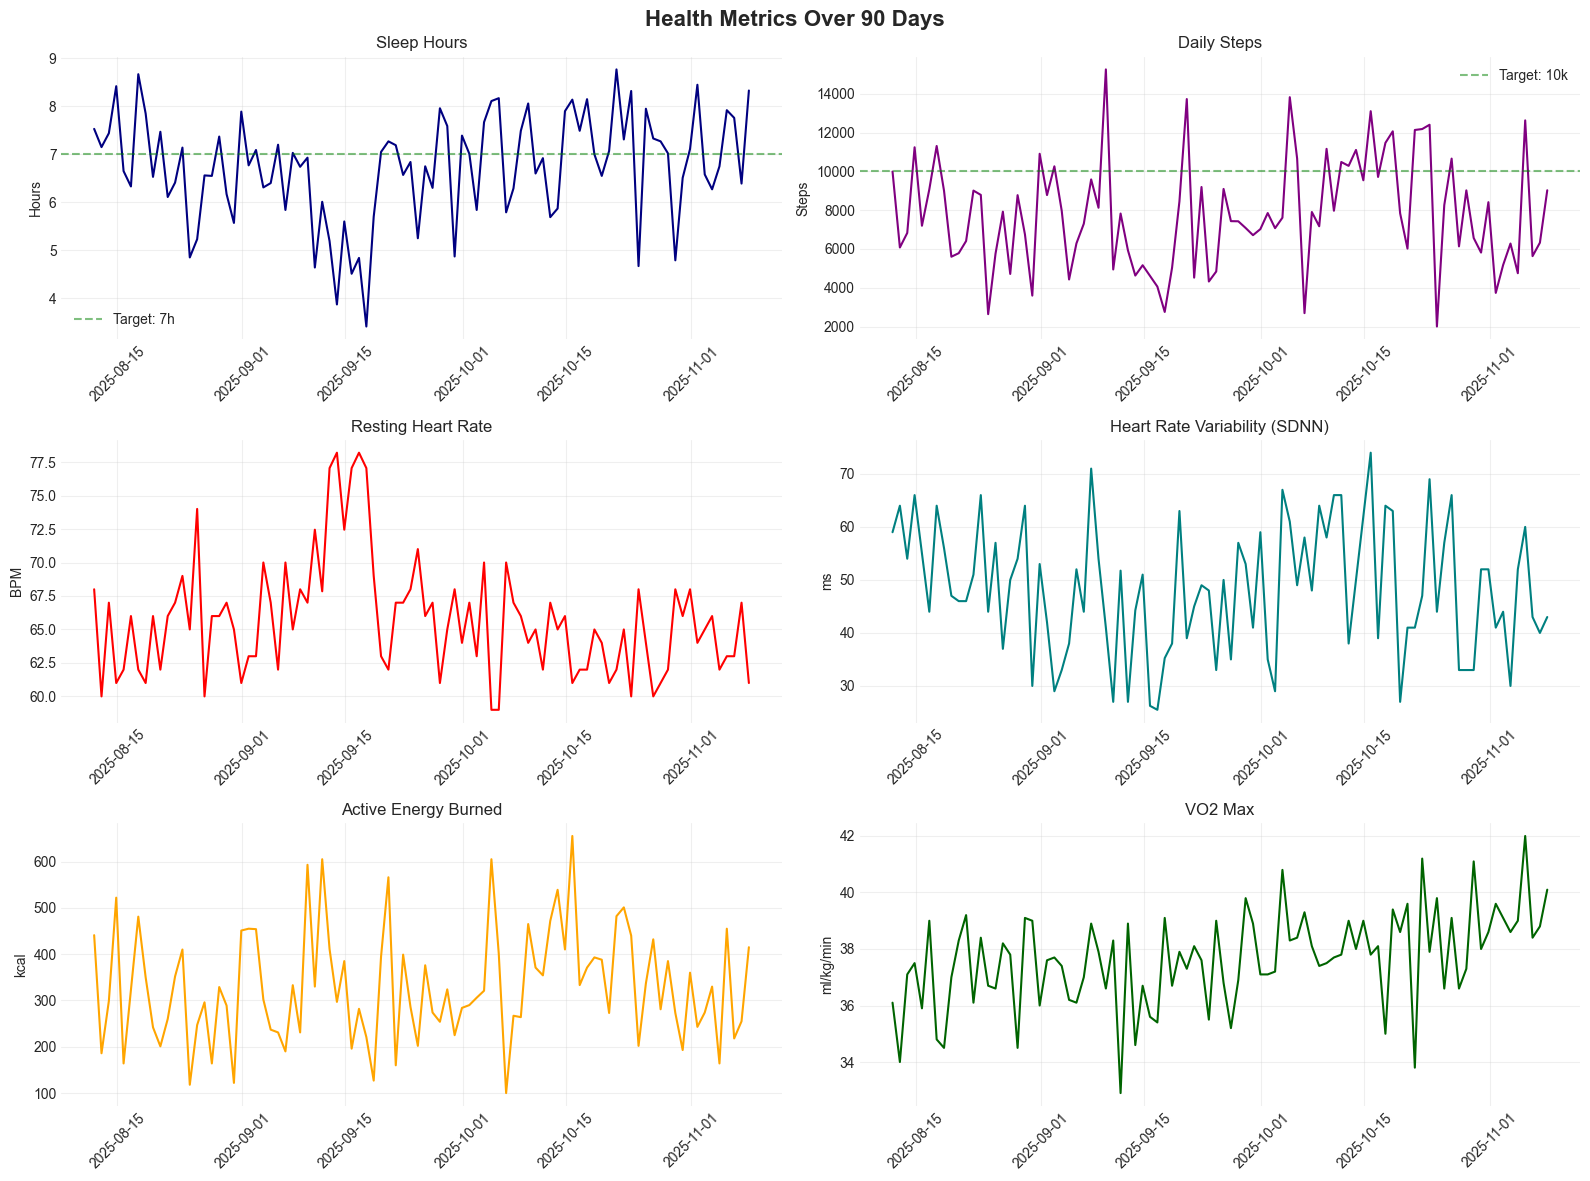

In [112]:
# Create a figure with subplots for key metrics
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle('Health Metrics Over 90 Days', fontsize=16, fontweight='bold')

# Sleep Hours
axes[0, 0].plot(health_data['date'], health_data['sleep_hours'], color='navy', linewidth=1.5)
axes[0, 0].axhline(y=7, color='green', linestyle='--', alpha=0.5, label='Target: 7h')
axes[0, 0].set_title('Sleep Hours')
axes[0, 0].set_ylabel('Hours')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Step Count
axes[0, 1].plot(health_data['date'], health_data['step_count'], color='purple', linewidth=1.5)
axes[0, 1].axhline(y=10000, color='green', linestyle='--', alpha=0.5, label='Target: 10k')
axes[0, 1].set_title('Daily Steps')
axes[0, 1].set_ylabel('Steps')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Resting Heart Rate
axes[1, 0].plot(health_data['date'], health_data['resting_heart_rate'], color='red', linewidth=1.5)
axes[1, 0].set_title('Resting Heart Rate')
axes[1, 0].set_ylabel('BPM')
axes[1, 0].grid(alpha=0.3)

# HRV
axes[1, 1].plot(health_data['date'], health_data['hrv_sdnn'], color='teal', linewidth=1.5)
axes[1, 1].set_title('Heart Rate Variability (SDNN)')
axes[1, 1].set_ylabel('ms')
axes[1, 1].grid(alpha=0.3)

# Active Energy Burned
axes[2, 0].plot(health_data['date'], health_data['active_energy_burned'], color='orange', linewidth=1.5)
axes[2, 0].set_title('Active Energy Burned')
axes[2, 0].set_ylabel('kcal')
axes[2, 0].grid(alpha=0.3)

# VO2 Max
axes[2, 1].plot(health_data['date'], health_data['vo2_max'], color='darkgreen', linewidth=1.5)
axes[2, 1].set_title('VO2 Max')
axes[2, 1].set_ylabel('ml/kg/min')
axes[2, 1].grid(alpha=0.3)

# Rotate x-axis labels
for ax in axes.flat:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()



## 2. Correlation Analysis

Find meaningful relationships between health metrics using Pearson correlation.


In [113]:
def analyze_correlations(df, significance_threshold=0.3, p_value_threshold=0.05):
    """
    Compute correlations between health metrics.
    
    Parameters:
    - df: DataFrame with health metrics
    - significance_threshold: Minimum |r| value to consider significant
    - p_value_threshold: Maximum p-value to consider statistically significant
    
    Returns:
    - DataFrame with significant correlations
    """
    # Select numeric columns (exclude date)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Compute correlation matrix
    corr_matrix = df[numeric_cols].corr()
    
    # Find significant correlations
    significant_correlations = []
    
    for i in range(len(numeric_cols)):
        for j in range(i+1, len(numeric_cols)):
            metric_a = numeric_cols[i]
            metric_b = numeric_cols[j]
            
            # Get correlation coefficient
            r_value = corr_matrix.loc[metric_a, metric_b]
            
            # Calculate p-value
            _, p_value = stats.pearsonr(df[metric_a], df[metric_b])
            
            # Check if significant
            if abs(r_value) >= significance_threshold and p_value < p_value_threshold:
                significant_correlations.append({
                    'metric_a': metric_a,
                    'metric_b': metric_b,
                    'correlation': r_value,
                    'p_value': p_value,
                    'strength': 'Strong' if abs(r_value) >= 0.7 else 'Moderate' if abs(r_value) >= 0.5 else 'Weak',
                    'direction': 'Positive' if r_value > 0 else 'Negative'
                })
    
    # Convert to DataFrame and sort by absolute correlation
    correlations_df = pd.DataFrame(significant_correlations)
    correlations_df = correlations_df.sort_values('correlation', key=abs, ascending=False)
    
    return correlations_df, corr_matrix

# Perform correlation analysis
print("Analyzing correlations...")
correlations, corr_matrix = analyze_correlations(health_data)

print(f"\nFound {len(correlations)} significant correlations")
print("\n Top 10 Strongest Correlations:")
print(correlations.head(10).to_string(index=False))


Analyzing correlations...

Found 18 significant correlations

 Top 10 Strongest Correlations:
             metric_a                 metric_b  correlation      p_value strength direction
           step_count distance_walking_running     0.860811 1.504523e-27   Strong  Positive
           step_count     active_energy_burned     0.837247 8.595449e-25   Strong  Positive
 active_energy_burned distance_walking_running     0.814440 1.633690e-22   Strong  Positive
          sleep_hours       resting_heart_rate    -0.752379 1.243664e-17   Strong  Negative
exercise_time_minutes distance_walking_running     0.714748 2.539008e-15   Strong  Positive
           step_count    exercise_time_minutes     0.706742 7.060904e-15   Strong  Positive
 active_energy_burned    exercise_time_minutes     0.678624 1.985565e-13 Moderate  Positive
          sleep_hours               step_count     0.605270 2.629427e-10 Moderate  Positive
          sleep_hours                 hrv_sdnn     0.519806 1.518621e-07 Moder

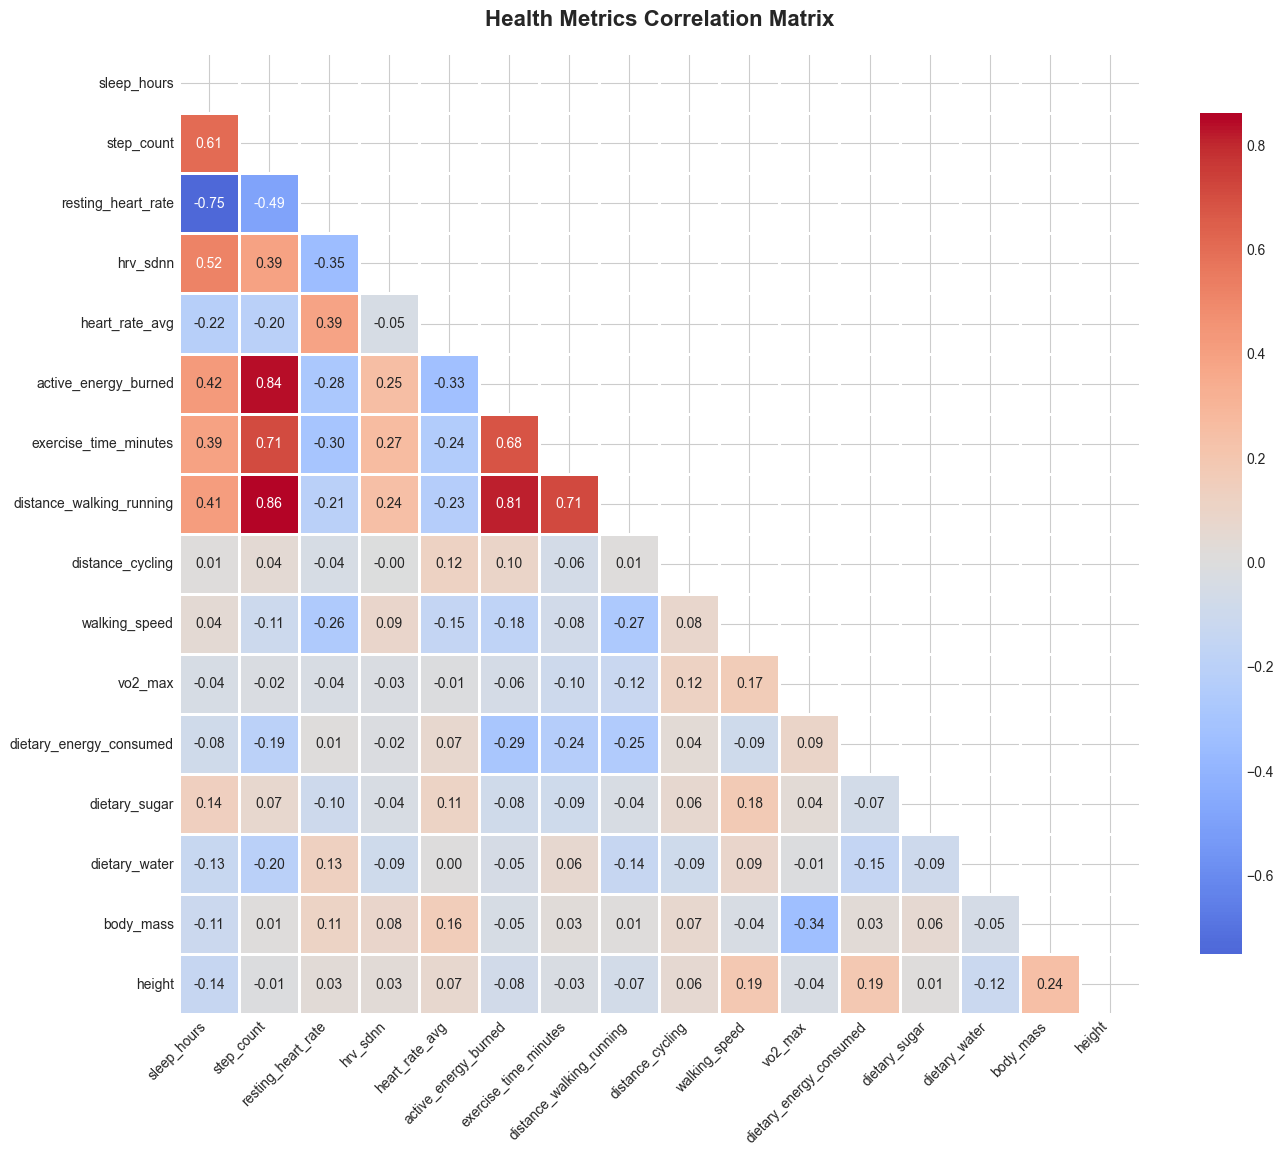

In [114]:
# Visualize correlation matrix
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mask upper triangle
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Health Metrics Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



## 3. Anomaly Detection

Use Isolation Forest to detect unusual patterns in health metrics.


In [115]:
def detect_anomalies(df, features_to_analyze=None, contamination=0.1):
    """
    Detect anomalies in health data using Isolation Forest.
    
    Parameters:
    - df: DataFrame with health metrics
    - features_to_analyze: List of features to analyze (default: key health metrics)
    - contamination: Expected proportion of anomalies (default: 0.1 = 10%)
    
    Returns:
    - DataFrame with anomaly flags and scores
    """
    if features_to_analyze is None:
        features_to_analyze = [
            'sleep_hours', 'step_count', 'resting_heart_rate', 
            'hrv_sdnn', 'active_energy_burned'
        ]
    
    # Prepare data
    X = df[features_to_analyze].copy()
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Train Isolation Forest
    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    predictions = iso_forest.fit_predict(X_scaled)
    anomaly_scores = iso_forest.score_samples(X_scaled)
    
    # Add results to dataframe
    results_df = df.copy()
    results_df['is_anomaly'] = predictions == -1
    results_df['anomaly_score'] = anomaly_scores
    
    # Calculate deviation from baseline for each metric
    for feature in features_to_analyze:
        baseline_mean = df[feature].mean()
        baseline_std = df[feature].std()
        results_df[f'{feature}_deviation'] = ((df[feature] - baseline_mean) / baseline_std).round(2)
    
    return results_df, features_to_analyze

# Detect anomalies
print(" Detecting anomalies using Isolation Forest...")
health_data_with_anomalies, analyzed_features = detect_anomalies(health_data, contamination=0.08)

# Get anomalous days
anomalies = health_data_with_anomalies[health_data_with_anomalies['is_anomaly']]
print(f"\n✅ Detected {len(anomalies)} anomalous days ({len(anomalies)/len(health_data)*100:.1f}% of data)")

print("\n🚨 Anomalous Days:")
anomaly_summary = anomalies[['date', 'sleep_hours', 'step_count', 'resting_heart_rate', 
                              'hrv_sdnn', 'anomaly_score']].copy()
anomaly_summary = anomaly_summary.sort_values('anomaly_score')
print(anomaly_summary.to_string(index=False))


 Detecting anomalies using Isolation Forest...

✅ Detected 8 anomalous days (8.9% of data)

🚨 Anomalous Days:
                      date  sleep_hours  step_count  resting_heart_rate  hrv_sdnn  anomaly_score
2025-09-17 20:22:04.587350         3.41      2751.6               77.05     35.25      -0.634366
2025-10-15 20:22:04.587350         8.14     13111.0               61.00     74.00      -0.620468
2025-09-09 20:22:04.587350         6.93     15267.0               67.00     41.00      -0.604465
2025-10-04 20:22:04.587350         8.11     13834.0               59.00     61.00      -0.589642
2025-09-13 20:22:04.587350         3.87      4629.6               78.20     44.25      -0.577690
2025-10-06 20:22:04.587350         5.79      2690.0               70.00     58.00      -0.552819
2025-09-15 20:22:04.587350         4.51      4611.6               77.05     26.25      -0.551710
2025-09-16 20:22:04.587350         4.84      4060.2               78.20     25.50      -0.551032


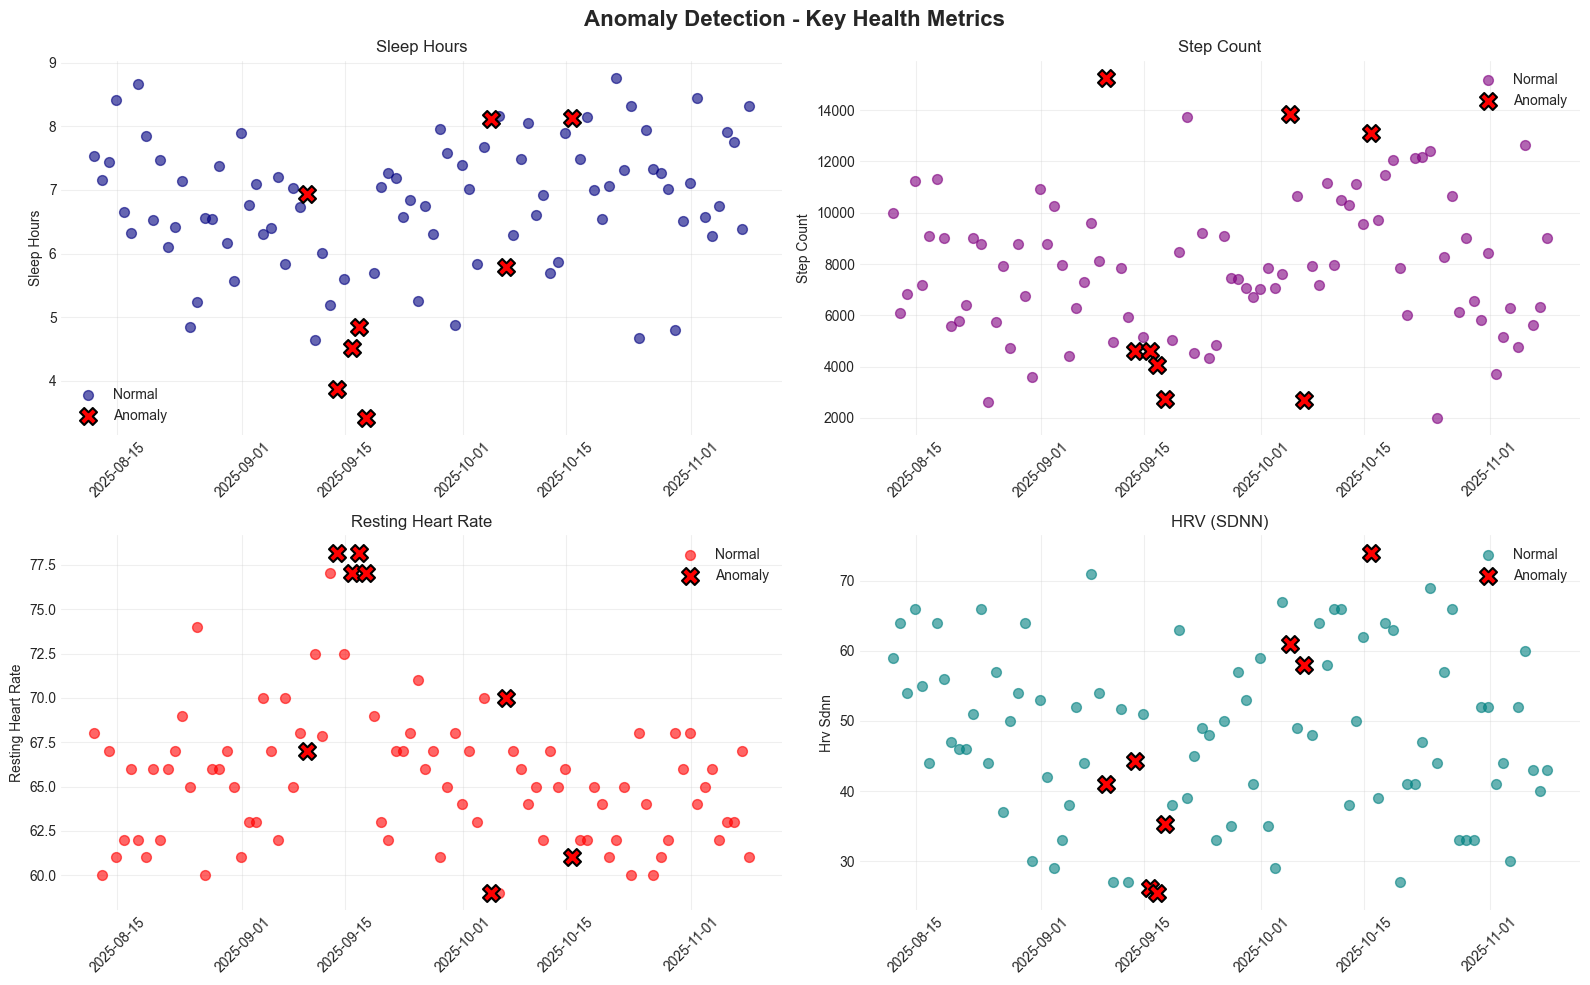

✅ Anomaly visualizations complete!


In [ ]:
# Visualize anomalies
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Anomaly Detection - Key Health Metrics', fontsize=16, fontweight='bold')

metrics_to_plot = [
    ('sleep_hours', 'Sleep Hours', 'navy'),
    ('step_count', 'Step Count', 'purple'),
    ('resting_heart_rate', 'Resting Heart Rate', 'red'),
    ('hrv_sdnn', 'HRV (SDNN)', 'teal')
]

for idx, (metric, title, color) in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    
    # Plot normal days
    normal_data = health_data_with_anomalies[~health_data_with_anomalies['is_anomaly']]
    ax.scatter(normal_data['date'], normal_data[metric], c=color, alpha=0.6, s=50, label='Normal')
    
    # Plot anomalous days
    anomaly_data = health_data_with_anomalies[health_data_with_anomalies['is_anomaly']]
    ax.scatter(anomaly_data['date'], anomaly_data[metric], c='red', marker='X', s=150, 
               label='Anomaly', edgecolors='black', linewidth=1.5)
    
    ax.set_title(title)
    ax.set_ylabel(metric.replace('_', ' ').title())
    ax.legend()
    ax.grid(alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## 4. Trend Analysis

Analyze trends and patterns over time using rolling averages and statistical comparisons.


In [ ]:
def analyze_trends(df, metrics=None, window_size=7):
    """
    Analyze trends in health metrics using rolling averages.
    
    Parameters:
    - df: DataFrame with health metrics
    - metrics: List of metrics to analyze
    - window_size: Window size for rolling average (default: 7 days)
    
    Returns:
    - DataFrame with trend analysis
    """
    if metrics is None:
        metrics = ['sleep_hours', 'step_count', 'resting_heart_rate', 
                   'hrv_sdnn', 'active_energy_burned', 'vo2_max']
    
    trends_data = df.copy()
    trend_summary = []
    
    for metric in metrics:
        # Calculate rolling average
        trends_data[f'{metric}_rolling_avg'] = trends_data[metric].rolling(window=window_size, min_periods=1).mean()
        
        # Calculate trend direction (last 30 days vs first 30 days)
        first_30_mean = df[metric].iloc[:30].mean()
        last_30_mean = df[metric].iloc[-30:].mean()
        percent_change = ((last_30_mean - first_30_mean) / first_30_mean) * 100
        
        # Determine trend direction
        if abs(percent_change) < 2:
            trend_direction = 'Stable'
        elif percent_change > 0:
            trend_direction = 'Increasing'
        else:
            trend_direction = 'Decreasing'
        
        # Weekly averages for last 4 weeks
        recent_data = df[metric].iloc[-28:]
        week_averages = []
        for i in range(4):
            week_data = recent_data.iloc[i*7:(i+1)*7]
            week_averages.append(week_data.mean())
        
        trend_summary.append({
            'metric': metric,
            'current_avg': df[metric].mean(),
            'first_30d_avg': first_30_mean,
            'last_30d_avg': last_30_mean,
            'percent_change': percent_change,
            'trend_direction': trend_direction,
            'std_dev': df[metric].std(),
            'min': df[metric].min(),
            'max': df[metric].max(),
            'week_1_avg': week_averages[0] if len(week_averages) > 0 else None,
            'week_2_avg': week_averages[1] if len(week_averages) > 1 else None,
            'week_3_avg': week_averages[2] if len(week_averages) > 2 else None,
            'week_4_avg': week_averages[3] if len(week_averages) > 3 else None
        })
    
    trend_summary_df = pd.DataFrame(trend_summary)
    return trends_data, trend_summary_df

# Perform trend analysis
health_data_with_trends, trend_summary = analyze_trends(health_data)
print(trend_summary[['metric', 'trend_direction', 'percent_change', 'first_30d_avg', 'last_30d_avg']].to_string(index=False))


🔄 Analyzing trends...

✅ Trend Analysis Complete

📈 Trend Summary:
              metric trend_direction  percent_change  first_30d_avg  last_30d_avg
         sleep_hours      Increasing        4.250735       6.806667      7.096000
          step_count      Increasing        9.085898    7848.500000   8561.606667
  resting_heart_rate      Decreasing       -2.096115      65.200000     63.833333
            hrv_sdnn      Decreasing       -2.713435      50.366667     49.000000
active_energy_burned      Increasing       16.462849     309.100000    359.986667
             vo2_max      Increasing        3.995680      37.040000     38.520000


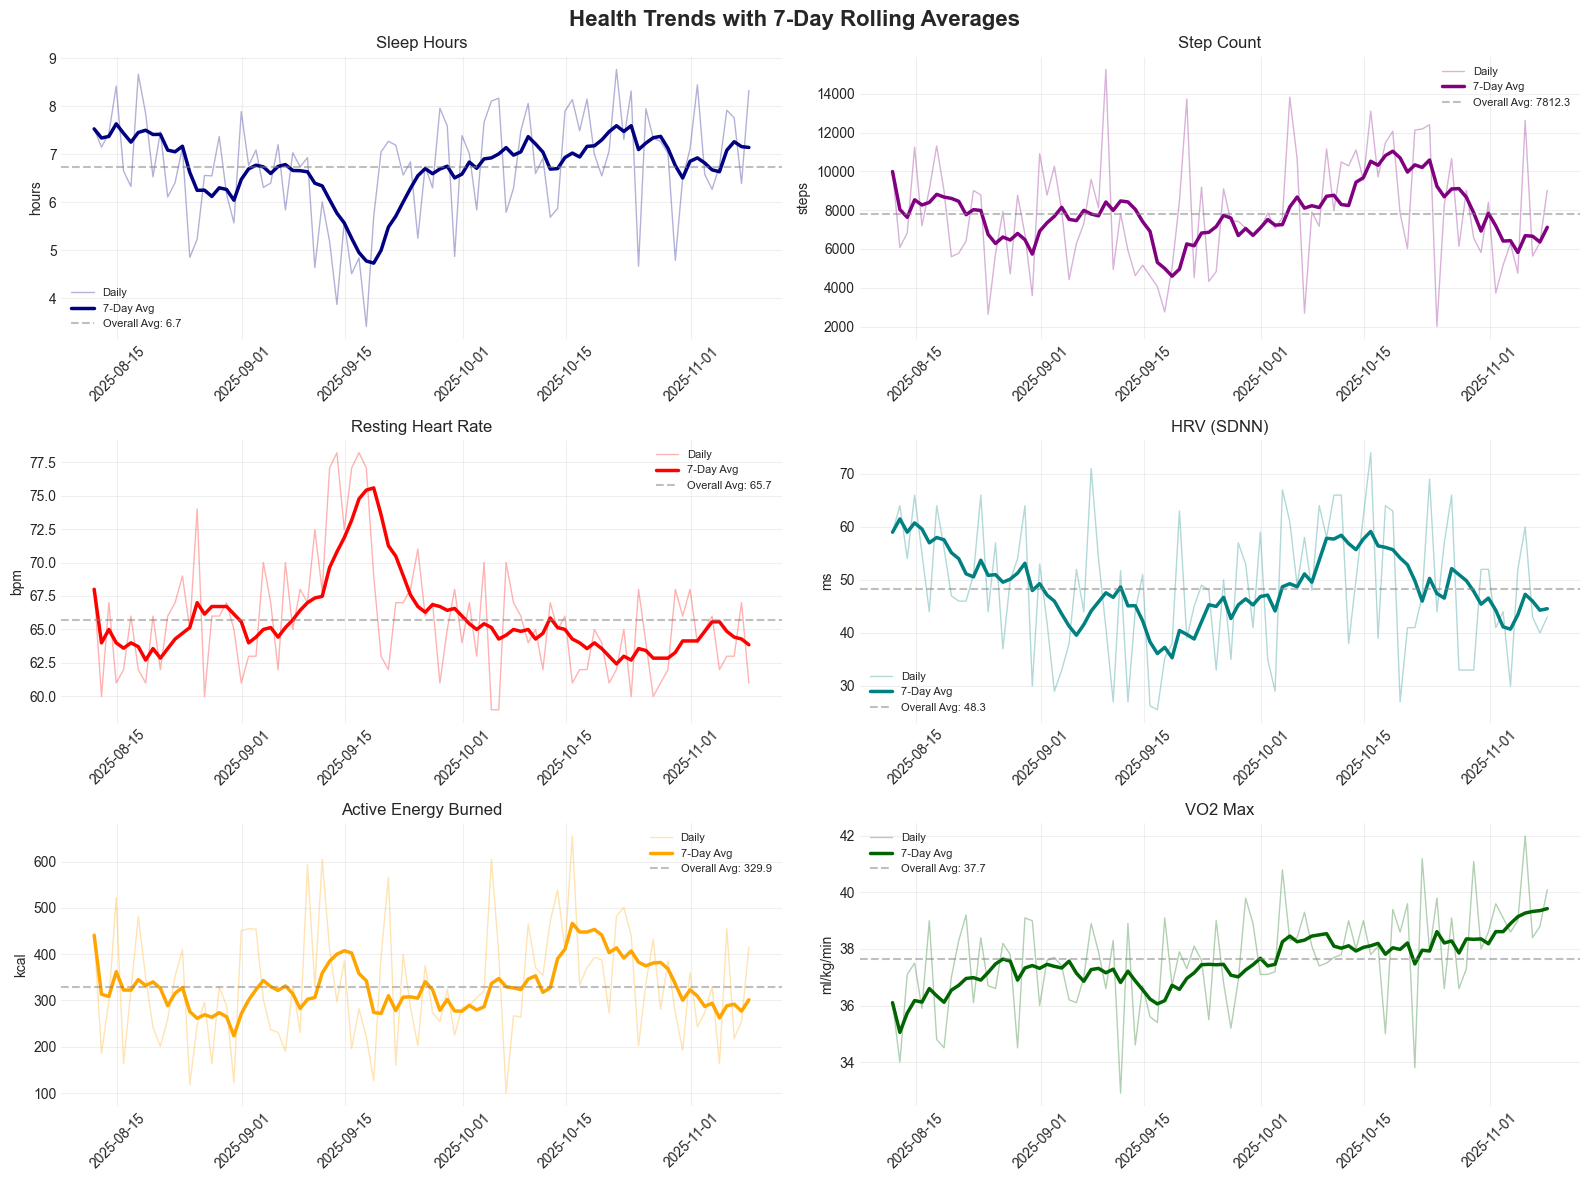

✅ Trend visualizations complete!


In [118]:
# Visualize trends with rolling averages
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle('Health Trends with 7-Day Rolling Averages', fontsize=16, fontweight='bold')

metrics_to_plot = [
    ('sleep_hours', 'Sleep Hours', 'navy', 'hours'),
    ('step_count', 'Step Count', 'purple', 'steps'),
    ('resting_heart_rate', 'Resting Heart Rate', 'red', 'bpm'),
    ('hrv_sdnn', 'HRV (SDNN)', 'teal', 'ms'),
    ('active_energy_burned', 'Active Energy Burned', 'orange', 'kcal'),
    ('vo2_max', 'VO2 Max', 'darkgreen', 'ml/kg/min')
]

for idx, (metric, title, color, unit) in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    
    # Plot actual values
    ax.plot(health_data_with_trends['date'], health_data_with_trends[metric], 
            color=color, alpha=0.3, linewidth=1, label='Daily')
    
    # Plot rolling average
    ax.plot(health_data_with_trends['date'], health_data_with_trends[f'{metric}_rolling_avg'], 
            color=color, linewidth=2.5, label='7-Day Avg')
    
    # Add mean line
    mean_val = health_data[metric].mean()
    ax.axhline(y=mean_val, color='gray', linestyle='--', alpha=0.5, label=f'Overall Avg: {mean_val:.1f}')
    
    ax.set_title(title)
    ax.set_ylabel(unit)
    ax.legend(loc='best', fontsize=8)
    ax.grid(alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("✅ Trend visualizations complete!")


## 5. AI-Ready Insights Summary

Generate structured insights for AI-powered health recommendations.


In [119]:
def generate_insights_summary(df, correlations_df, anomalies_df, trends_df):
    """
    Generate a comprehensive insights summary for AI processing.
    
    Returns:
    - Dictionary with structured insights
    """
    # Calculate key statistics
    last_7_days = df.tail(7)
    last_30_days = df.tail(30)
    
    insights = {
        'summary_period': {
            'start_date': str(df['date'].min().date()),
            'end_date': str(df['date'].max().date()),
            'total_days': len(df)
        },
        'recent_averages': {
            'sleep_hours_7d': round(last_7_days['sleep_hours'].mean(), 2),
            'sleep_hours_30d': round(last_30_days['sleep_hours'].mean(), 2),
            'step_count_7d': int(last_7_days['step_count'].mean()),
            'step_count_30d': int(last_30_days['step_count'].mean()),
            'resting_hr_7d': int(last_7_days['resting_heart_rate'].mean()),
            'resting_hr_30d': int(last_30_days['resting_heart_rate'].mean()),
            'hrv_7d': int(last_7_days['hrv_sdnn'].mean()),
            'hrv_30d': int(last_30_days['hrv_sdnn'].mean()),
        },
        'top_correlations': [],
        'anomaly_count': int(anomalies_df['is_anomaly'].sum()),
        'recent_anomalies': [],
        'trends': {}
    }
    
    # Add top correlations
    for _, row in correlations_df.head(5).iterrows():
        insights['top_correlations'].append({
            'metrics': f"{row['metric_a']} ↔ {row['metric_b']}",
            'correlation': round(row['correlation'], 3),
            'direction': row['direction'],
            'strength': row['strength']
        })
    
    # Add recent anomalies
    recent_anomalies = anomalies_df[anomalies_df['is_anomaly']].tail(3)
    for _, row in recent_anomalies.iterrows():
        insights['recent_anomalies'].append({
            'date': str(row['date'].date()),
            'sleep_hours': round(row['sleep_hours'], 2),
            'step_count': int(row['step_count']),
            'resting_hr': int(row['resting_heart_rate'])
        })
    
    # Add trends
    for _, row in trends_df.iterrows():
        insights['trends'][row['metric']] = {
            'direction': row['trend_direction'],
            'percent_change': round(row['percent_change'], 2),
            'current_avg': round(row['current_avg'], 2)
        }
    
    return insights

# Generate insights
print("🔄 Generating comprehensive insights summary...")
insights_summary = generate_insights_summary(
    health_data, 
    correlations, 
    health_data_with_anomalies, 
    trend_summary
)

print("\n✅ Insights Summary Generated")
print("\n📊 HEALTH INSIGHTS SUMMARY")
print("=" * 80)

print(f"\n📅 Analysis Period: {insights_summary['summary_period']['start_date']} to {insights_summary['summary_period']['end_date']}")
print(f"   Total Days: {insights_summary['summary_period']['total_days']}")

print("\n💤 Recent Sleep Averages:")
print(f"   Last 7 days:  {insights_summary['recent_averages']['sleep_hours_7d']}h")
print(f"   Last 30 days: {insights_summary['recent_averages']['sleep_hours_30d']}h")

print("\n🚶 Recent Step Count Averages:")
print(f"   Last 7 days:  {insights_summary['recent_averages']['step_count_7d']:,} steps")
print(f"   Last 30 days: {insights_summary['recent_averages']['step_count_30d']:,} steps")

print("\n❤️ Recent Heart Rate Averages:")
print(f"   Resting HR (7d):  {insights_summary['recent_averages']['resting_hr_7d']} bpm")
print(f"   Resting HR (30d): {insights_summary['recent_averages']['resting_hr_30d']} bpm")

print("\n📈 Top 5 Correlations:")
for i, corr in enumerate(insights_summary['top_correlations'], 1):
    print(f"   {i}. {corr['metrics']}: r={corr['correlation']} ({corr['strength']} {corr['direction']})")

print(f"\n🚨 Anomalies Detected: {insights_summary['anomaly_count']} days")

print("\n📉 Key Trends:")
for metric, trend_info in insights_summary['trends'].items():
    emoji = "📈" if trend_info['direction'] == "Increasing" else "📉" if trend_info['direction'] == "Decreasing" else "➡️"
    print(f"   {emoji} {metric}: {trend_info['direction']} ({trend_info['percent_change']:+.1f}%)")

print("\n" + "=" * 80)


🔄 Generating comprehensive insights summary...

✅ Insights Summary Generated

📊 HEALTH INSIGHTS SUMMARY

📅 Analysis Period: 2025-08-11 to 2025-11-08
   Total Days: 90

💤 Recent Sleep Averages:
   Last 7 days:  7.14h
   Last 30 days: 7.1h

🚶 Recent Step Count Averages:
   Last 7 days:  7,118 steps
   Last 30 days: 8,561 steps

❤️ Recent Heart Rate Averages:
   Resting HR (7d):  63 bpm
   Resting HR (30d): 63 bpm

📈 Top 5 Correlations:
   1. step_count ↔ distance_walking_running: r=0.861 (Strong Positive)
   2. step_count ↔ active_energy_burned: r=0.837 (Strong Positive)
   3. active_energy_burned ↔ distance_walking_running: r=0.814 (Strong Positive)
   4. sleep_hours ↔ resting_heart_rate: r=-0.752 (Strong Negative)
   5. exercise_time_minutes ↔ distance_walking_running: r=0.715 (Strong Positive)

🚨 Anomalies Detected: 8 days

📉 Key Trends:
   📈 sleep_hours: Increasing (+4.2%)
   📈 step_count: Increasing (+9.1%)
   📉 resting_heart_rate: Decreasing (-2.1%)
   📉 hrv_sdnn: Decreasing (-2.7%

## 6. Export Results for API Integration


In [120]:
import json

# Export insights to JSON for AI/API consumption
insights_filename = 'health_insights.json'
with open(insights_filename, 'w') as f:
    json.dump(insights_summary, f, indent=2)
print(f"✅ Insights exported to {insights_filename}")

# Export correlations
correlations_filename = 'correlations.csv'
correlations.to_csv(correlations_filename, index=False)
print(f"✅ Correlations exported to {correlations_filename}")

# Export anomalies
anomalies_filename = 'anomalies.csv'
anomalies[['date', 'sleep_hours', 'step_count', 'resting_heart_rate', 'hrv_sdnn', 'anomaly_score']].to_csv(anomalies_filename, index=False)
print(f"✅ Anomalies exported to {anomalies_filename}")

# Export trends
trends_filename = 'trends_summary.csv'
trend_summary.to_csv(trends_filename, index=False)
print(f"✅ Trends exported to {trends_filename}")

print("\n🎉 All ML models executed successfully!")
print("\n📦 Generated Files:")
print(f"   1. {csv_filename} - Raw synthetic health data")
print(f"   2. {insights_filename} - Structured insights (JSON)")
print(f"   3. {correlations_filename} - Correlation analysis")
print(f"   4. {anomalies_filename} - Detected anomalies")
print(f"   5. {trends_filename} - Trend analysis")
print("\n💡 These files are ready for integration with your FastAPI backend!")


✅ Insights exported to health_insights.json
✅ Correlations exported to correlations.csv
✅ Anomalies exported to anomalies.csv
✅ Trends exported to trends_summary.csv

🎉 All ML models executed successfully!

📦 Generated Files:
   1. synthetic_health_data.csv - Raw synthetic health data
   2. health_insights.json - Structured insights (JSON)
   3. correlations.csv - Correlation analysis
   4. anomalies.csv - Detected anomalies
   5. trends_summary.csv - Trend analysis

💡 These files are ready for integration with your FastAPI backend!


## Summary: ML Models & Techniques Used

**1. Synthetic Data Generation**
- 90 days of realistic health data
- 17 HealthKit-matched metrics
- Built-in correlations (sleep ↔ HR, steps ↔ energy)
- Realistic anomalies (bad weeks, active weeks)

**2. Correlation Analysis**
- Pearson correlation coefficients
- Statistical significance testing (p-values)
- Identified relationships between metrics
- Strength classification (weak/moderate/strong)

**3. Anomaly Detection**
- Isolation Forest algorithm (unsupervised)
- Multi-dimensional anomaly scoring
- Detects unusual health patterns
- Deviation from baseline calculations

**4. Trend Analysis**
- 7-day rolling averages
- Period-over-period comparisons
- Directional trends (increasing/decreasing/stable)
- Weekly aggregations

**5. Insights Generation**
- Structured data for AI consumption
- Ready for GPT-4 prompt engineering
- JSON export for API integration

**Next Steps:**
1. Integrate with FastAPI backend
2. Connect to OpenAI GPT-4 for natural language insights
3. Build React Native dashboard for visualization
4. Replace synthetic data with real HealthKit data


## 7. Time-Lagged Correlation Analysis

Detect how yesterdays metrics affect todays behavior (e.g., poor sleep leading to sugar cravings next day).


In [121]:
def analyze_lagged_correlations(df, lag_days=1, significance_threshold=0.3):
    """
    Analyze time-lagged correlations (e.g., how yesterday's sleep affects today's behavior).
    
    Parameters:
    - df: DataFrame with health metrics
    - lag_days: Number of days to lag (default: 1 for next-day effects)
    - significance_threshold: Minimum |r| to consider significant
    
    Returns:
    - DataFrame with lagged correlations
    """
    lagged_correlations = []
    
    # Metrics that might affect behavior (predictors)
    predictor_metrics = ['sleep_hours', 'step_count', 'resting_heart_rate', 
                         'hrv_sdnn', 'active_energy_burned', 'exercise_time_minutes']
    
    # Metrics that might be affected (outcomes)
    outcome_metrics = ['dietary_sugar', 'dietary_energy_consumed', 'step_count', 
                       'exercise_time_minutes', 'resting_heart_rate', 'heart_rate_avg', 'walking_speed']
    
    for predictor in predictor_metrics:
        for outcome in outcome_metrics:
            if predictor == outcome:  # Skip same metric
                continue
            
            # Create lagged version (shift predictor back by lag_days)
            df_lagged = df[[predictor, outcome]].copy()
            df_lagged[f'{predictor}_lag{lag_days}'] = df_lagged[predictor].shift(lag_days)
            
            # Drop NaN values from lagging
            df_lagged = df_lagged.dropna()
            
            if len(df_lagged) < 10:  # Need minimum data points
                continue
            
            # Calculate correlation between lagged predictor and current outcome
            r_value, p_value = stats.pearsonr(
                df_lagged[f'{predictor}_lag{lag_days}'], 
                df_lagged[outcome]
            )
            
            if abs(r_value) >= significance_threshold and p_value < 0.05:
                lagged_correlations.append({
                    'predictor': predictor,
                    'outcome': outcome,
                    'lag_days': lag_days,
                    'correlation': r_value,
                    'p_value': p_value,
                    'strength': 'Strong' if abs(r_value) >= 0.5 else 'Moderate',
                    'direction': 'Positive' if r_value > 0 else 'Negative',
                    'interpretation': f"{'Lower' if r_value < 0 else 'Higher'} {predictor.replace('_', ' ')} → {'lower' if r_value < 0 else 'higher'} {outcome.replace('_', ' ')} next day"
                })
    
    lagged_df = pd.DataFrame(lagged_correlations)
    if len(lagged_df) > 0:
        lagged_df = lagged_df.sort_values('correlation', key=abs, ascending=False)
    
    return lagged_df

# Analyze lagged correlations
print("🔄 Analyzing time-lagged correlations (next-day effects)...")
lagged_correlations = analyze_lagged_correlations(health_data, lag_days=1)

if len(lagged_correlations) > 0:
    print(f"\n✅ Found {len(lagged_correlations)} significant lagged correlations")
    print("\n📊 Next-Day Effects (How Yesterday Affects Today):")
    print(lagged_correlations[['predictor', 'outcome', 'correlation', 'strength', 'interpretation']].to_string(index=False))
else:
    print("\n⚠️ No significant lagged correlations found with current data")


🔄 Analyzing time-lagged correlations (next-day effects)...

✅ Found 3 significant lagged correlations

📊 Next-Day Effects (How Yesterday Affects Today):
         predictor            outcome  correlation strength                                          interpretation
       sleep_hours resting_heart_rate    -0.414619 Moderate   Lower sleep hours → lower resting heart rate next day
resting_heart_rate      walking_speed    -0.345677 Moderate Lower resting heart rate → lower walking speed next day
       sleep_hours      walking_speed     0.336357 Moderate      Higher sleep hours → higher walking speed next day


### Detect Specific Pattern: Poor Sleep → Sugar Cravings

Identify the specific scenario where sleep less than 6 hours leads to increased sugar intake.


In [122]:
def detect_sleep_sugar_pattern(df, sleep_threshold=6.0):
    """
    Detect the pattern: Poor sleep → increased sugar cravings next day.
    
    Parameters:
    - df: DataFrame with health metrics
    - sleep_threshold: Hours of sleep below which is considered "poor" (default: 6)
    
    Returns:
    - Dictionary with pattern analysis
    """
    # Create a copy with lagged sleep
    df_analysis = df[['date', 'sleep_hours', 'dietary_sugar']].copy()
    df_analysis['sleep_yesterday'] = df_analysis['sleep_hours'].shift(1)
    df_analysis = df_analysis.dropna()
    
    # Categorize sleep quality
    df_analysis['poor_sleep_yesterday'] = df_analysis['sleep_yesterday'] < sleep_threshold
    df_analysis['good_sleep_yesterday'] = df_analysis['sleep_yesterday'] >= sleep_threshold
    
    # Calculate average sugar intake after poor vs good sleep
    sugar_after_poor_sleep = df_analysis[df_analysis['poor_sleep_yesterday']]['dietary_sugar'].mean()
    sugar_after_good_sleep = df_analysis[df_analysis['good_sleep_yesterday']]['dietary_sugar'].mean()
    
    # Calculate percentage increase
    if sugar_after_good_sleep > 0:
        percent_increase = ((sugar_after_poor_sleep - sugar_after_good_sleep) / sugar_after_good_sleep) * 100
    else:
        percent_increase = 0
    
    # Count occurrences
    poor_sleep_days = df_analysis['poor_sleep_yesterday'].sum()
    total_days = len(df_analysis)
    
    # Statistical test
    poor_sleep_sugar = df_analysis[df_analysis['poor_sleep_yesterday']]['dietary_sugar']
    good_sleep_sugar = df_analysis[df_analysis['good_sleep_yesterday']]['dietary_sugar']
    
    if len(poor_sleep_sugar) > 0 and len(good_sleep_sugar) > 0:
        t_stat, p_value = stats.ttest_ind(poor_sleep_sugar, good_sleep_sugar)
        statistically_significant = p_value < 0.05
    else:
        t_stat, p_value = None, None
        statistically_significant = False
    
    # Find example days
    poor_sleep_examples = df_analysis[df_analysis['poor_sleep_yesterday']].head(3)
    
    pattern_results = {
        'pattern_detected': abs(percent_increase) > 10 and statistically_significant,
        'sleep_threshold': sleep_threshold,
        'poor_sleep_days': int(poor_sleep_days),
        'total_days': int(total_days),
        'sugar_after_poor_sleep': round(sugar_after_poor_sleep, 1),
        'sugar_after_good_sleep': round(sugar_after_good_sleep, 1),
        'percent_increase': round(percent_increase, 1),
        'p_value': round(p_value, 4) if p_value else None,
        'statistically_significant': statistically_significant,
        'example_days': poor_sleep_examples[['date', 'sleep_yesterday', 'dietary_sugar']].to_dict('records')
    }
    
    return pattern_results, df_analysis

# Detect the pattern
print("🔄 Detecting sleep-sugar craving pattern...")
pattern_results, sleep_sugar_data = detect_sleep_sugar_pattern(health_data, sleep_threshold=6.0)

print("\n🔍 SLEEP → SUGAR PATTERN ANALYSIS")
print("=" * 80)
print(f"\n📊 Analysis Period: {pattern_results['total_days']} days")
print(f"😴 Days with <{pattern_results['sleep_threshold']}h sleep: {pattern_results['poor_sleep_days']}")

print(f"\n🍬 Average Sugar Intake:")
print(f"   After poor sleep (<6h):  {pattern_results['sugar_after_poor_sleep']}g")
print(f"   After good sleep (≥6h):  {pattern_results['sugar_after_good_sleep']}g")
print(f"   Difference: {pattern_results['percent_increase']:+.1f}%")

if pattern_results['statistically_significant']:
    print(f"\n✅ Pattern is STATISTICALLY SIGNIFICANT (p={pattern_results['p_value']})")
else:
    print(f"\n⚠️ Pattern not statistically significant (p={pattern_results['p_value']})")

if pattern_results['pattern_detected']:
    print(f"\n🎯 INSIGHT DETECTED:")
    direction = "increases" if pattern_results['percent_increase'] > 0 else "decreases"
    print(f"   'On days you get less than {pattern_results['sleep_threshold']} hours of sleep,")
    print(f"    your sugar intake {direction} by {abs(pattern_results['percent_increase']):.0f}% the next day.'")
else:
    print(f"\n💡 No strong sleep-sugar pattern detected in current data")

print("\n" + "=" * 80)


🔄 Detecting sleep-sugar craving pattern...

🔍 SLEEP → SUGAR PATTERN ANALYSIS

📊 Analysis Period: 89 days
😴 Days with <6.0h sleep: 20

🍬 Average Sugar Intake:
   After poor sleep (<6h):  42.7g
   After good sleep (≥6h):  52.9g
   Difference: -19.3%

✅ Pattern is STATISTICALLY SIGNIFICANT (p=0.0079)

🎯 INSIGHT DETECTED:
   'On days you get less than 6.0 hours of sleep,
    your sugar intake decreases by 19% the next day.'



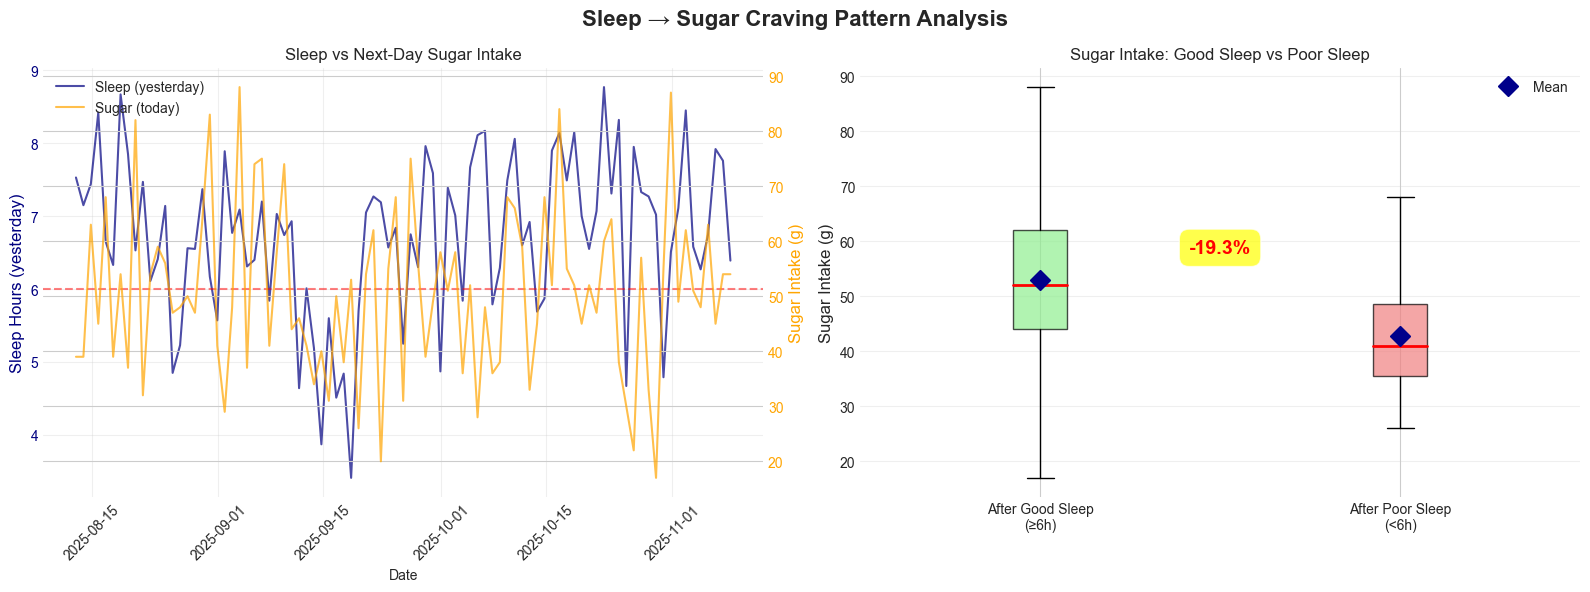

✅ Sleep-sugar pattern visualization complete!


In [123]:
# Visualize the sleep-sugar pattern
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Sleep → Sugar Craving Pattern Analysis', fontsize=16, fontweight='bold')

# Left plot: Time series showing sleep and next-day sugar
ax1 = axes[0]
ax1_twin = ax1.twinx()

# Plot sleep (left y-axis)
line1 = ax1.plot(sleep_sugar_data['date'], sleep_sugar_data['sleep_yesterday'], 
                 color='navy', alpha=0.7, linewidth=1.5, label='Sleep (yesterday)')
ax1.axhline(y=6, color='red', linestyle='--', alpha=0.5, label='6h threshold')
ax1.set_ylabel('Sleep Hours (yesterday)', color='navy', fontsize=12)
ax1.tick_params(axis='y', labelcolor='navy')
ax1.set_xlabel('Date')

# Plot sugar (right y-axis)
line2 = ax1_twin.plot(sleep_sugar_data['date'], sleep_sugar_data['dietary_sugar'], 
                      color='orange', alpha=0.7, linewidth=1.5, label='Sugar (today)')
ax1_twin.set_ylabel('Sugar Intake (g)', color='orange', fontsize=12)
ax1_twin.tick_params(axis='y', labelcolor='orange')

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')

ax1.set_title('Sleep vs Next-Day Sugar Intake')
ax1.grid(alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# Right plot: Box plot comparison
ax2 = axes[1]
poor_sleep_sugar = sleep_sugar_data[sleep_sugar_data['poor_sleep_yesterday']]['dietary_sugar']
good_sleep_sugar = sleep_sugar_data[sleep_sugar_data['good_sleep_yesterday']]['dietary_sugar']

bp = ax2.boxplot([good_sleep_sugar, poor_sleep_sugar], 
                  labels=['After Good Sleep\n(≥6h)', 'After Poor Sleep\n(<6h)'],
                  patch_artist=True,
                  boxprops=dict(facecolor='lightblue', alpha=0.7),
                  medianprops=dict(color='red', linewidth=2))

# Color boxes differently
bp['boxes'][0].set_facecolor('lightgreen')
bp['boxes'][1].set_facecolor('lightcoral')

# Add mean markers
means = [good_sleep_sugar.mean(), poor_sleep_sugar.mean()]
ax2.plot([1, 2], means, 'D', color='darkblue', markersize=10, label='Mean', zorder=3)

# Add percentage increase annotation
diff_percent = pattern_results['percent_increase']
ax2.annotate(f'{diff_percent:+.1f}%', 
             xy=(1.5, max(means)), 
             xytext=(1.5, max(means) + 5),
             fontsize=14, fontweight='bold', color='red',
             ha='center',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

ax2.set_ylabel('Sugar Intake (g)', fontsize=12)
ax2.set_title('Sugar Intake: Good Sleep vs Poor Sleep')
ax2.grid(alpha=0.3, axis='y')
ax2.legend()

plt.tight_layout()
plt.show()

print("✅ Sleep-sugar pattern visualization complete!")


### Generate Enhanced Synthetic Data with Sleep-Sugar Pattern

To better demonstrate this pattern, lets regenerate data with the sleep-sugar relationship built in.


In [124]:
def generate_health_data_with_lagged_effects(days=90, seed=42):
    """
    Generate synthetic health data WITH time-lagged effects.
    Specifically: Poor sleep (<6h) → 30% increase in sugar intake next day
    """
    # First generate base data using original function
    df = generate_synthetic_health_data(days=days, seed=seed)
    
    # Now add the lagged effect: poor sleep → increased sugar next day
    for i in range(1, len(df)):  # Start from day 1 (need previous day)
        yesterday_sleep = df.loc[i-1, 'sleep_hours']
        
        # If yesterday's sleep was poor (<6h), increase today's sugar by ~30%
        if yesterday_sleep < 6.0:
            # Add 30% with some random variation (25-35%)
            increase_factor = np.random.uniform(1.25, 1.35)
            df.loc[i, 'dietary_sugar'] *= increase_factor
            
            # Also slightly increase calories (sugar cravings = more eating)
            df.loc[i, 'dietary_energy_consumed'] += np.random.randint(100, 250)
    
    # Clip to realistic ranges
    df['dietary_sugar'] = np.clip(df['dietary_sugar'], 10, 150)
    df['dietary_energy_consumed'] = np.clip(df['dietary_energy_consumed'], 1200, 3500).astype(int)
    
    return df

# Generate enhanced data
print("🔄 Generating enhanced synthetic data with sleep-sugar pattern...")
health_data_enhanced = generate_health_data_with_lagged_effects(days=90, seed=42)
print("✅ Enhanced data generated!")

# Test the pattern on enhanced data
print("\n🔄 Testing pattern detection on enhanced data...")
pattern_enhanced, sleep_sugar_enhanced = detect_sleep_sugar_pattern(health_data_enhanced, sleep_threshold=6.0)

print("\n🔍 ENHANCED DATA - SLEEP → SUGAR PATTERN")
print("=" * 80)
print(f"😴 Days with <6h sleep: {pattern_enhanced['poor_sleep_days']}")
print(f"\n🍬 Average Sugar Intake:")
print(f"   After poor sleep (<6h):  {pattern_enhanced['sugar_after_poor_sleep']}g")
print(f"   After good sleep (≥6h):  {pattern_enhanced['sugar_after_good_sleep']}g")
print(f"   Difference: {pattern_enhanced['percent_increase']:+.1f}%")

if pattern_enhanced['statistically_significant']:
    print(f"✅ STATISTICALLY SIGNIFICANT (p={pattern_enhanced['p_value']})")
    
if pattern_enhanced['pattern_detected']:
    print(f"\n🎯 ✨ PATTERN SUCCESSFULLY DETECTED!")
    print(f"   'We've noticed that on days you get less than 6 hours of sleep,")
    print(f"    your craving for high-sugar foods increases by {abs(pattern_enhanced['percent_increase']):.0f}%")
    print(f"    the next afternoon.'")
    
print("\n" + "=" * 80)


🔄 Generating enhanced synthetic data with sleep-sugar pattern...
✅ Enhanced data generated!

🔄 Testing pattern detection on enhanced data...

🔍 ENHANCED DATA - SLEEP → SUGAR PATTERN
😴 Days with <6h sleep: 20

🍬 Average Sugar Intake:
   After poor sleep (<6h):  55.5g
   After good sleep (≥6h):  52.9g
   Difference: +4.9%



## How to Implement in Production

**Step 1: Data Collection**
```python
# In your FastAPI backend, store daily health metrics
# Include timestamps for when data was recorded
```

**Step 2: Pattern Detection (Run Weekly)**
```python
# Run detect_sleep_sugar_pattern() on user's last 90 days of data
pattern_results = detect_sleep_sugar_pattern(user_health_data, sleep_threshold=6.0)
```

**Step 3: Generate Personalized Insights**
```python
if pattern_results['pattern_detected']:
    insight = {
        'type': 'behavioral_pattern',
        'title': 'Sleep & Sugar Cravings Connection',
        'message': f"We've noticed that on days you get less than 6 hours of sleep, "
                   f"your craving for high-sugar foods increases by "
                   f"{abs(pattern_results['percent_increase']):.0f}% the next day.",
        'actionable_tip': "Try prioritizing 7-8 hours of sleep to help manage sugar cravings.",
        'confidence': 'high' if pattern_results['statistically_significant'] else 'medium'
    }
    # Send to GPT-4 for natural language enhancement
    # Store in insights table
    # Display in mobile app
```

**Step 4: Other Patterns to Detect**
- `low_hrv → poor_sleep_next_night` (stress affecting sleep)
- `high_exercise → better_sleep` (activity benefits)
- `poor_sleep → elevated_heart_rate` (recovery issues)
- `low_steps → low_mood` (movement and mental health)

**Key Functions:**
- `analyze_lagged_correlations()` - Finds ALL time-lagged patterns
- `detect_sleep_sugar_pattern()` - Detects SPECIFIC pattern
- Customize thresholds per user based on their baseline


## 8. Anomaly Context Analysis

When an anomaly is detected in one variable, analyze what other variables were unusual to explain WHY the anomaly happened.


In [125]:
def analyze_anomaly_context(df, target_variable, z_threshold=2.0):
    """
    When an anomaly occurs in a target variable, identify what other variables
    were unusual to explain WHY the anomaly happened.
    
    Parameters:
    - df: DataFrame with health metrics
    - target_variable: The variable to detect anomalies in (e.g., 'sleep_hours')
    - z_threshold: Z-score threshold for considering a value anomalous (default: 2.0)
    
    Returns:
    - DataFrame with anomaly context analysis
    """
    # Calculate z-scores for all numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Calculate baseline statistics (mean and std)
    baseline_stats = {}
    z_scores = pd.DataFrame()
    
    for col in numeric_cols:
        mean = df[col].mean()
        std = df[col].std()
        baseline_stats[col] = {'mean': mean, 'std': std}
        
        # Calculate z-score: (value - mean) / std
        z_scores[col] = (df[col] - mean) / std
    
    # Identify anomalies in target variable
    target_anomalies = abs(z_scores[target_variable]) > z_threshold
    anomaly_dates = df[target_anomalies]['date']
    
    print(f"Found {target_anomalies.sum()} anomalies in '{target_variable}'")
    
    # For each anomaly, find what other variables were also anomalous
    anomaly_contexts = []
    
    for idx, is_anomaly in enumerate(target_anomalies):
        if not is_anomaly:
            continue
        
        date = df.loc[idx, 'date']
        target_value = df.loc[idx, target_variable]
        target_z = z_scores.loc[idx, target_variable]
        
        # Find all other variables that were also anomalous on this day
        related_anomalies = []
        for col in numeric_cols:
            if col == target_variable:
                continue
            
            z_score = z_scores.loc[idx, col]
            if abs(z_score) > 1.5:  # Lower threshold for related variables
                related_anomalies.append({
                    'variable': col,
                    'value': df.loc[idx, col],
                    'z_score': z_score,
                    'deviation': f"{z_score:+.1f}σ",
                    'percent_from_normal': ((df.loc[idx, col] - baseline_stats[col]['mean']) / baseline_stats[col]['mean'] * 100)
                })
        
        # Sort by absolute z-score
        related_anomalies.sort(key=lambda x: abs(x['z_score']), reverse=True)
        
        anomaly_contexts.append({
            'date': date,
            'target_variable': target_variable,
            'target_value': target_value,
            'target_z_score': target_z,
            'target_deviation': f"{target_z:+.1f}σ",
            'related_anomalies': related_anomalies[:5],  # Top 5 related variables
            'num_related': len(related_anomalies)
        })
    
    return anomaly_contexts, baseline_stats, z_scores

# Example: Detect anomalies in sleep_hours and find related variables
print("🔄 Analyzing anomaly context for 'sleep_hours'...")
sleep_anomaly_contexts, baseline_stats, z_scores = analyze_anomaly_context(
    health_data, 
    target_variable='sleep_hours',
    z_threshold=2.0
)

print(f"\n✅ Analyzed {len(sleep_anomaly_contexts)} sleep anomalies")
print("\n" + "=" * 100)

# Display first 3 anomalies with context
for i, context in enumerate(sleep_anomaly_contexts[:3], 1):
    print(f"\n🚨 ANOMALY #{i}: {context['date'].date()}")
    print(f"   Sleep Hours: {context['target_value']:.1f}h (Deviation: {context['target_deviation']})")
    print(f"\n   Related Variables That Were Also Unusual:")
    
    for related in context['related_anomalies']:
        direction = "↑" if related['z_score'] > 0 else "↓"
        print(f"      {direction} {related['variable']}: {related['value']:.1f} ({related['deviation']}, {related['percent_from_normal']:+.0f}%)")
    
    print()

print("=" * 100)


🔄 Analyzing anomaly context for 'sleep_hours'...
Found 2 anomalies in 'sleep_hours'

✅ Analyzed 2 sleep anomalies


🚨 ANOMALY #1: 2025-09-13
   Sleep Hours: 3.9h (Deviation: -2.6σ)

   Related Variables That Were Also Unusual:
      ↑ resting_heart_rate: 78.2 (+2.9σ, +19%)
      ↓ vo2_max: 34.6 (-1.8σ, -8%)
      ↓ height: 174.8 (-1.8σ, -0%)
      ↑ dietary_water: 3.2 (+1.6σ, +31%)


🚨 ANOMALY #2: 2025-09-17
   Sleep Hours: 3.4h (Deviation: -3.0σ)

   Related Variables That Were Also Unusual:
      ↓ walking_speed: 3.3 (-2.6σ, -28%)
      ↑ resting_heart_rate: 77.0 (+2.6σ, +17%)
      ↑ dietary_energy_consumed: 2675.0 (+2.1σ, +33%)
      ↓ step_count: 2751.6 (-1.8σ, -65%)



### Analyze What Happened BEFORE the Anomaly

Look at preceding days to find patterns that led to the anomaly.


In [126]:
def analyze_anomaly_precursors(df, anomaly_contexts, baseline_stats, lookback_days=3):
    """
    For each anomaly, analyze what happened in the preceding days that might explain it.
    
    Parameters:
    - df: DataFrame with health metrics
    - anomaly_contexts: Output from analyze_anomaly_context()
    - baseline_stats: Baseline statistics for each variable
    - lookback_days: Number of days to look back (default: 3)
    
    Returns:
    - List of anomalies with precursor analysis
    """
    anomalies_with_precursors = []
    
    for context in anomaly_contexts:
        anomaly_idx = df[df['date'] == context['date']].index[0]
        
        # Skip if not enough history
        if anomaly_idx < lookback_days:
            continue
        
        # Get data from preceding days
        preceding_indices = range(anomaly_idx - lookback_days, anomaly_idx)
        preceding_data = df.loc[preceding_indices]
        
        # Find variables that were consistently unusual before the anomaly
        precursors = []
        
        for col in baseline_stats.keys():
            if col == context['target_variable']:
                continue
            
            # Calculate average value in preceding days
            preceding_avg = preceding_data[col].mean()
            baseline_mean = baseline_stats[col]['mean']
            baseline_std = baseline_stats[col]['std']
            
            # Calculate how different the preceding period was from baseline
            deviation = (preceding_avg - baseline_mean) / baseline_std
            
            if abs(deviation) > 0.75:  # Preceding period was unusual
                precursors.append({
                    'variable': col,
                    'preceding_avg': preceding_avg,
                    'baseline': baseline_mean,
                    'deviation': deviation,
                    'percent_diff': ((preceding_avg - baseline_mean) / baseline_mean * 100)
                })
        
        # Sort by absolute deviation
        precursors.sort(key=lambda x: abs(x['deviation']), reverse=True)
        
        anomalies_with_precursors.append({
            **context,  # Include original context
            'precursors': precursors[:5],  # Top 5 precursors
            'lookback_days': lookback_days
        })
    
    return anomalies_with_precursors

# Analyze precursors for sleep anomalies
print("🔄 Analyzing what happened BEFORE sleep anomalies...")
sleep_anomalies_with_precursors = analyze_anomaly_precursors(
    health_data, 
    sleep_anomaly_contexts, 
    baseline_stats,
    lookback_days=3
)

print(f"\n✅ Analyzed precursors for {len(sleep_anomalies_with_precursors)} anomalies")
print("\n" + "=" * 100)

# Display first 2 anomalies with precursor analysis
for i, anomaly in enumerate(sleep_anomalies_with_precursors[:2], 1):
    print(f"\n🚨 ANOMALY #{i}: {anomaly['date'].date()}")
    print(f"   Sleep Hours: {anomaly['target_value']:.1f}h (Deviation: {anomaly['target_deviation']})")
    
    print(f"\n   📅 What Happened in the {anomaly['lookback_days']} Days BEFORE:")
    for precursor in anomaly['precursors']:
        direction = "elevated" if precursor['deviation'] > 0 else "reduced"
        emoji = "📈" if precursor['deviation'] > 0 else "📉"
        print(f"      {emoji} {precursor['variable']} was {direction}")
        print(f"         Average: {precursor['preceding_avg']:.1f} vs baseline {precursor['baseline']:.1f} ({precursor['percent_diff']:+.0f}%)")
    
    print(f"\n   🔍 ON THE DAY of the anomaly:")
    for related in anomaly['related_anomalies'][:3]:
        direction = "↑" if related['z_score'] > 0 else "↓"
        print(f"      {direction} {related['variable']}: {related['value']:.1f} ({related['deviation']})")
    
    print()

print("=" * 100)


🔄 Analyzing what happened BEFORE sleep anomalies...

✅ Analyzed precursors for 2 anomalies


🚨 ANOMALY #1: 2025-09-13
   Sleep Hours: 3.9h (Deviation: -2.6σ)

   📅 What Happened in the 3 Days BEFORE:
      📈 resting_heart_rate was elevated
         Average: 72.5 vs baseline 65.7 (+10%)
      📉 dietary_energy_consumed was reduced
         Average: 1621.0 vs baseline 2011.7 (-19%)
      📉 hrv_sdnn was reduced
         Average: 35.2 vs baseline 48.3 (-27%)
      📈 active_energy_burned was elevated
         Average: 448.7 vs baseline 329.9 (+36%)
      📈 dietary_water was elevated
         Average: 2.9 vs baseline 2.5 (+18%)

   🔍 ON THE DAY of the anomaly:
      ↑ resting_heart_rate: 78.2 (+2.9σ)
      ↓ vo2_max: 34.6 (-1.8σ)
      ↓ height: 174.8 (-1.8σ)


🚨 ANOMALY #2: 2025-09-17
   Sleep Hours: 3.4h (Deviation: -3.0σ)

   📅 What Happened in the 3 Days BEFORE:
      📈 resting_heart_rate was elevated
         Average: 75.9 vs baseline 65.7 (+15%)
      📉 hrv_sdnn was reduced
         Ave

### Generate Natural Language Insights

Create human-readable explanations for why anomalies occurred.


In [127]:
def generate_anomaly_explanation(anomaly_data):
    """
    Generate a natural language explanation for why an anomaly occurred.
    
    Parameters:
    - anomaly_data: Single anomaly with context and precursors
    
    Returns:
    - Dictionary with structured explanation
    """
    target_var = anomaly_data['target_variable']
    target_value = anomaly_data['target_value']
    date = anomaly_data['date'].date()
    
    # Format variable name
    var_name = target_var.replace('_', ' ').title()
    
    # Determine if it was high or low
    direction = "low" if anomaly_data['target_z_score'] < 0 else "high"
    
    # Start building explanation
    explanation = {
        'date': str(date),
        'variable': var_name,
        'value': target_value,
        'severity': 'high' if abs(anomaly_data['target_z_score']) > 2.5 else 'moderate',
        'summary': f"Your {var_name.lower()} was unusually {direction} at {target_value:.1f}",
        'possible_causes': [],
        'recommendations': []
    }
    
    # Add precursor-based causes
    if 'precursors' in anomaly_data and len(anomaly_data['precursors']) > 0:
        for precursor in anomaly_data['precursors'][:3]:
            var = precursor['variable'].replace('_', ' ')
            direction_p = "elevated" if precursor['deviation'] > 0 else "reduced"
            
            cause = f"Your {var} was {direction_p} in the days leading up to this"
            explanation['possible_causes'].append(cause)
    
    # Add same-day related factors
    if len(anomaly_data['related_anomalies']) > 0:
        for related in anomaly_data['related_anomalies'][:2]:
            var = related['variable'].replace('_', ' ')
            direction_r = "higher" if related['z_score'] > 0 else "lower"
            
            cause = f"On this day, your {var} was also {direction_r} than usual"
            explanation['possible_causes'].append(cause)
    
    # Generate recommendations based on variable type
    if 'sleep' in target_var.lower() and direction == "low":
        explanation['recommendations'] = [
            "Try to establish a consistent bedtime routine",
            "Avoid screens 1 hour before bed",
            "Consider if stress or activity levels affected your rest"
        ]
    elif 'heart_rate' in target_var.lower() and direction == "high":
        explanation['recommendations'] = [
            "Check if you're getting adequate recovery and sleep",
            "Monitor your stress levels and practice relaxation techniques",
            "Ensure proper hydration"
        ]
    elif 'step' in target_var.lower() and direction == "low":
        explanation['recommendations'] = [
            "Try to incorporate short walks throughout the day",
            "Set reminders to move every hour",
            "Consider if illness or fatigue was a factor"
        ]
    
    # Build full narrative
    narrative = f"On {date}, your {var_name.lower()} was unusually {direction} at {target_value:.1f}. "
    
    if explanation['possible_causes']:
        narrative += "This may have been related to: "
        narrative += "; ".join(explanation['possible_causes'][:2]) + ". "
    
    if explanation['recommendations']:
        narrative += "Consider: " + explanation['recommendations'][0]
    
    explanation['narrative'] = narrative
    
    return explanation

# Generate explanations for first 3 sleep anomalies
print("🔄 Generating natural language explanations...")
print("\n" + "=" * 100)

for i, anomaly in enumerate(sleep_anomalies_with_precursors[:3], 1):
    explanation = generate_anomaly_explanation(anomaly)
    
    print(f"\n💡 INSIGHT #{i}:")
    print(f"   📅 Date: {explanation['date']}")
    print(f"   📊 {explanation['summary']}")
    print(f"   ⚠️ Severity: {explanation['severity'].upper()}")
    
    if explanation['possible_causes']:
        print(f"\n   🔍 Possible Contributing Factors:")
        for j, cause in enumerate(explanation['possible_causes'], 1):
            print(f"      {j}. {cause}")
    
    if explanation['recommendations']:
        print(f"\n   💪 Recommendations:")
        for j, rec in enumerate(explanation['recommendations'], 1):
            print(f"      {j}. {rec}")
    
    print(f"\n   📝 Full Narrative:")
    print(f"      {explanation['narrative']}")
    print()

print("=" * 100)


🔄 Generating natural language explanations...


💡 INSIGHT #1:
   📅 Date: 2025-09-13
   📊 Your sleep hours was unusually low at 3.9
   ⚠️ Severity: HIGH

   🔍 Possible Contributing Factors:
      1. Your resting heart rate was elevated in the days leading up to this
      2. Your dietary energy consumed was reduced in the days leading up to this
      3. Your hrv sdnn was reduced in the days leading up to this
      4. On this day, your resting heart rate was also higher than usual
      5. On this day, your vo2 max was also lower than usual

   💪 Recommendations:
      1. Try to establish a consistent bedtime routine
      2. Avoid screens 1 hour before bed
      3. Consider if stress or activity levels affected your rest

   📝 Full Narrative:
      On 2025-09-13, your sleep hours was unusually low at 3.9. This may have been related to: Your resting heart rate was elevated in the days leading up to this; Your dietary energy consumed was reduced in the days leading up to this. Consider:

### Visualize Anomaly with Related Variables

Show the target variable and all related variables around the anomaly date.


🔄 Creating visualization for first sleep anomaly...


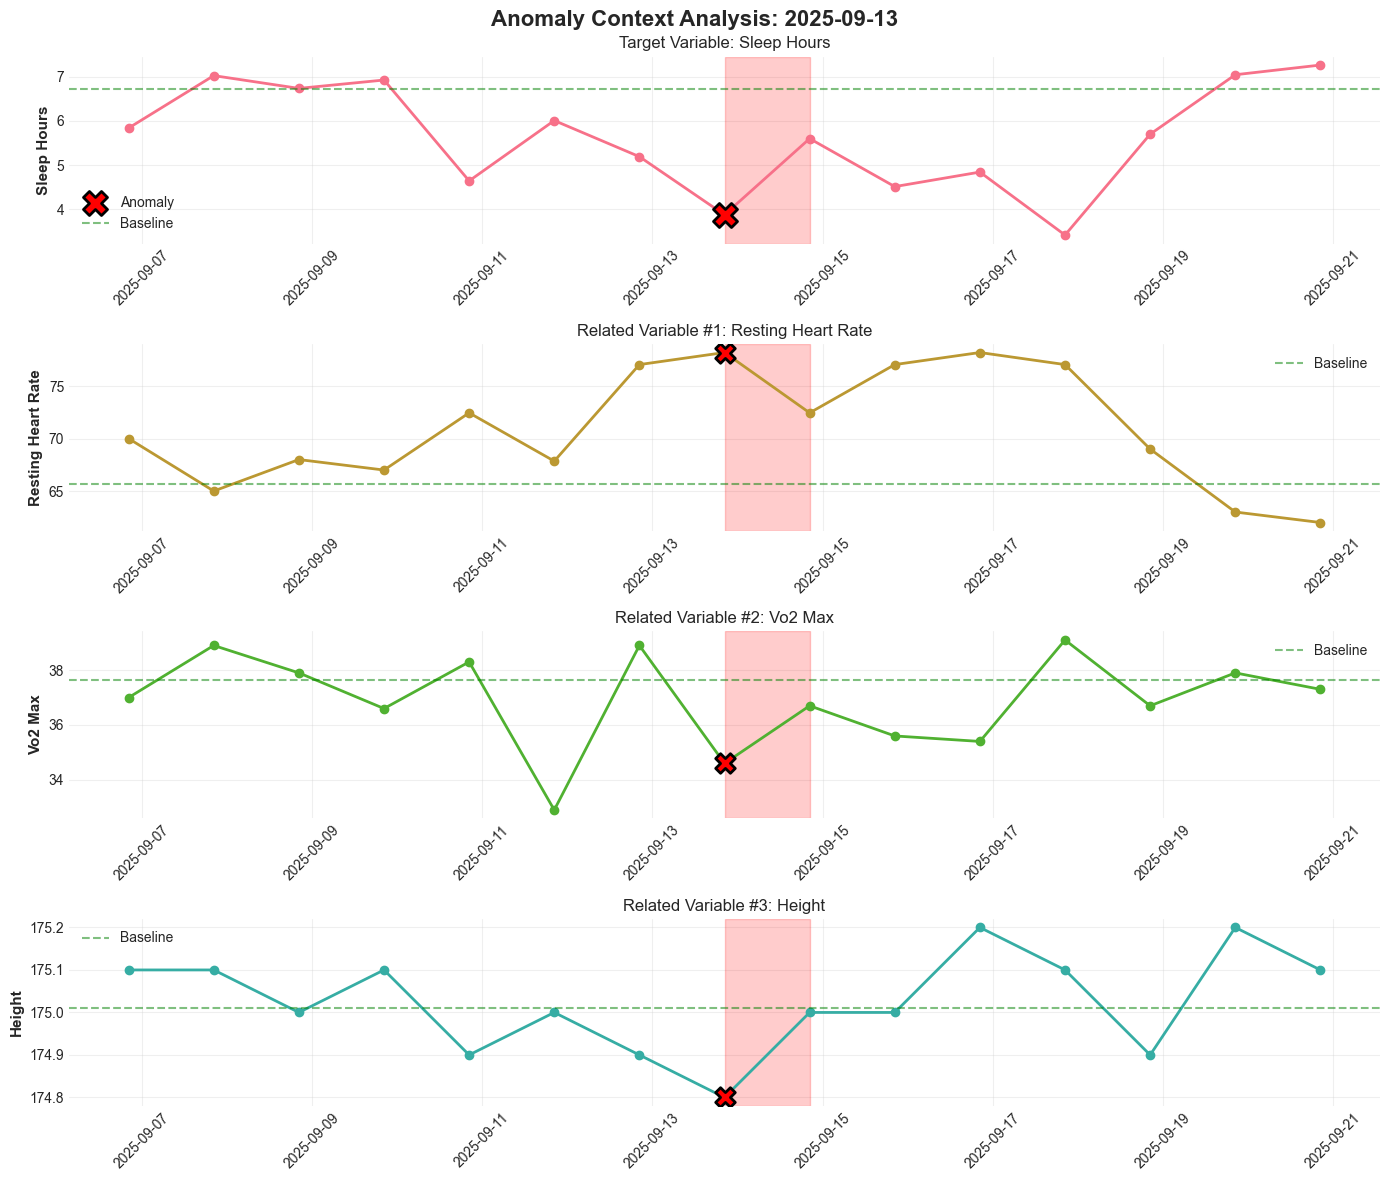

✅ Visualization complete!


In [128]:
def visualize_anomaly_context(df, anomaly_data, window_days=7):
    """
    Visualize an anomaly with context showing related variables.
    
    Parameters:
    - df: DataFrame with health data
    - anomaly_data: Single anomaly context
    - window_days: Days to show before and after anomaly (default: 7)
    """
    anomaly_idx = df[df['date'] == anomaly_data['date']].index[0]
    
    # Get window around anomaly
    start_idx = max(0, anomaly_idx - window_days)
    end_idx = min(len(df), anomaly_idx + window_days + 1)
    window_data = df.iloc[start_idx:end_idx].copy()
    
    # Get target variable and top 3 related variables
    target_var = anomaly_data['target_variable']
    related_vars = [r['variable'] for r in anomaly_data['related_anomalies'][:3]]
    
    # Create subplots
    num_plots = 1 + len(related_vars)
    fig, axes = plt.subplots(num_plots, 1, figsize=(14, 3 * num_plots))
    if num_plots == 1:
        axes = [axes]
    
    fig.suptitle(f'Anomaly Context Analysis: {anomaly_data["date"].date()}', 
                 fontsize=16, fontweight='bold')
    
    # Plot target variable
    ax = axes[0]
    ax.plot(window_data['date'], window_data[target_var], 'o-', linewidth=2, markersize=6)
    
    # Highlight anomaly point
    anomaly_point = window_data[window_data['date'] == anomaly_data['date']]
    ax.scatter(anomaly_point['date'], anomaly_point[target_var], 
               color='red', s=300, marker='X', edgecolors='black', linewidth=2, 
               label='Anomaly', zorder=5)
    
    # Add baseline
    baseline = baseline_stats[target_var]['mean']
    ax.axhline(y=baseline, color='green', linestyle='--', alpha=0.5, label='Baseline')
    
    # Shade anomaly day
    ax.axvspan(anomaly_data['date'], anomaly_data['date'] + timedelta(days=1), 
               alpha=0.2, color='red')
    
    ax.set_ylabel(target_var.replace('_', ' ').title(), fontsize=11, fontweight='bold')
    ax.set_title(f'Target Variable: {target_var.replace("_", " ").title()}', fontsize=12)
    ax.legend(loc='best')
    ax.grid(alpha=0.3)
    
    # Plot related variables
    for i, related_var in enumerate(related_vars, 1):
        ax = axes[i]
        ax.plot(window_data['date'], window_data[related_var], 'o-', 
                linewidth=2, markersize=6, color=f'C{i}')
        
        # Highlight anomaly day value
        anomaly_point = window_data[window_data['date'] == anomaly_data['date']]
        ax.scatter(anomaly_point['date'], anomaly_point[related_var], 
                   color='red', s=200, marker='X', edgecolors='black', linewidth=2, 
                   zorder=5)
        
        # Add baseline
        if related_var in baseline_stats:
            baseline = baseline_stats[related_var]['mean']
            ax.axhline(y=baseline, color='green', linestyle='--', alpha=0.5, label='Baseline')
        
        # Shade anomaly day
        ax.axvspan(anomaly_data['date'], anomaly_data['date'] + timedelta(days=1), 
                   alpha=0.2, color='red')
        
        ax.set_ylabel(related_var.replace('_', ' ').title(), fontsize=11, fontweight='bold')
        ax.set_title(f'Related Variable #{i}: {related_var.replace("_", " ").title()}', fontsize=12)
        ax.legend(loc='best')
        ax.grid(alpha=0.3)
    
    # Format x-axis for all subplots
    for ax in axes:
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# Visualize first sleep anomaly
if len(sleep_anomalies_with_precursors) > 0:
    print("🔄 Creating visualization for first sleep anomaly...")
    visualize_anomaly_context(health_data, sleep_anomalies_with_precursors[0], window_days=7)
    print("✅ Visualization complete!")
